In [1]:
import mne
import numpy as np
import pyedflib
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from IPython.display import Image
from IPython.core.display import HTML 


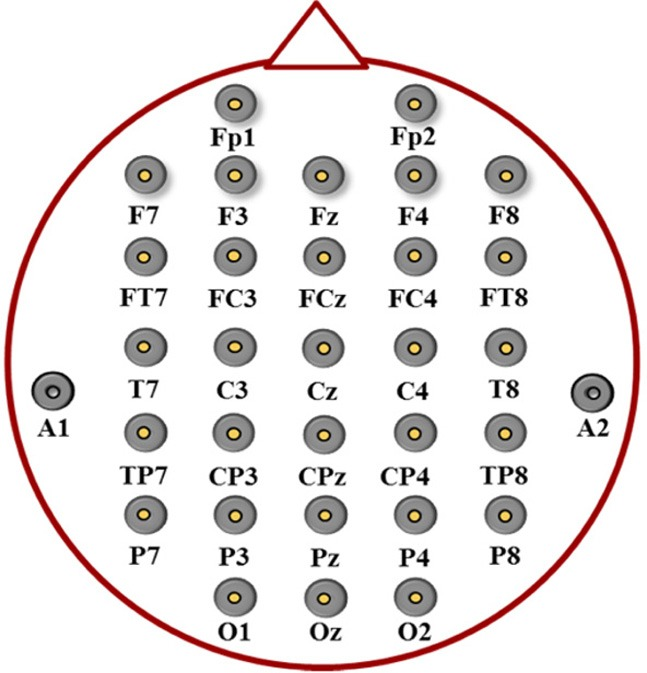

In [2]:
Image(filename = "../Electrode-placements-of-32-channels-according-to-the-international-10-20-system.jpeg", width=500, height=500)

In [39]:
filename = "../train/01_tcp_ar/00000005/s03_2010_10_02/00000005_s03_a00.edf"
f = pyedflib.EdfReader(filename)

In [40]:
n = f.signals_in_file
signal_labels = f.getSignalLabels()

In [6]:
dict(zip(np.arange(0, len(signal_labels)), signal_labels))

#We see that all the the system is based on a single reference electrode.


{0: 'EEG FP1-REF',
 1: 'EEG FP2-REF',
 2: 'EEG F3-REF',
 3: 'EEG F4-REF',
 4: 'EEG C3-REF',
 5: 'EEG C4-REF',
 6: 'EEG P3-REF',
 7: 'EEG P4-REF',
 8: 'EEG O1-REF',
 9: 'EEG O2-REF',
 10: 'EEG F7-REF',
 11: 'EEG F8-REF',
 12: 'EEG T3-REF',
 13: 'EEG T4-REF',
 14: 'EEG T5-REF',
 15: 'EEG T6-REF',
 16: 'EEG A1-REF',
 17: 'EEG A2-REF',
 18: 'EEG FZ-REF',
 19: 'EEG CZ-REF',
 20: 'EEG PZ-REF',
 21: 'EEG ROC-REF',
 22: 'EEG LOC-REF',
 23: 'EEG EKG1-REF',
 24: 'EMG-REF',
 25: 'EEG 26-REF',
 26: 'EEG 27-REF',
 27: 'EEG 28-REF',
 28: 'EEG 29-REF',
 29: 'EEG 30-REF',
 30: 'EEG T1-REF',
 31: 'EEG T2-REF',
 32: 'PHOTIC-REF',
 33: 'IBI',
 34: 'BURSTS',
 35: 'SUPPR'}

In [80]:
sigbufs = np.zeros((n-3, f.getNSamples()[0]))
print(sigbufs.shape)
for i in np.arange(n-3):
    sigbufs[i, :] = f.readSignal(i)

(33, 290500)


In [56]:
import matplotlib.pyplot as plt

%matplotlib inline

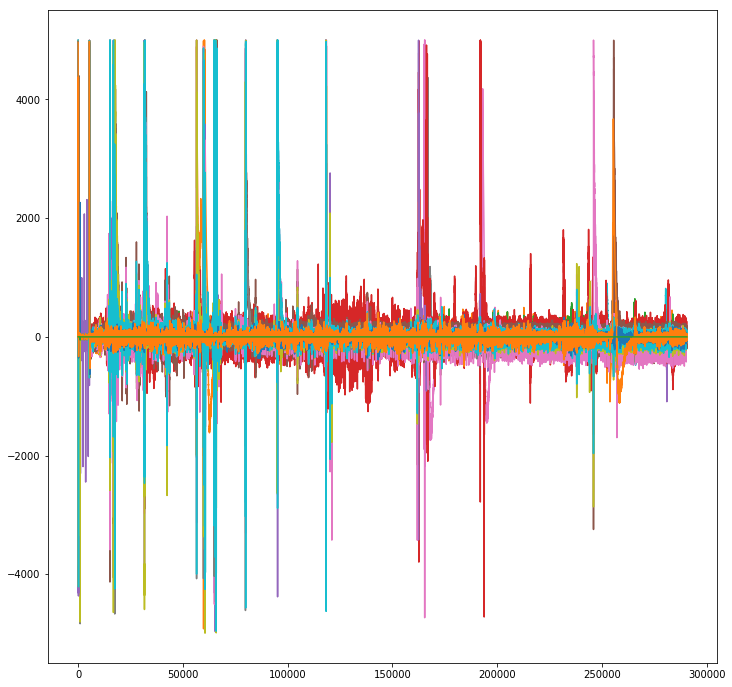

In [81]:
plt.figure(figsize=(12, 12))
for i in range(n-3):
    plt.plot(np.arange(1, sigbufs.shape[1]+1), sigbufs[i])

In [87]:
labels = open("../train/01_tcp_ar/00000005/s03_2010_10_02/00000005_s03_a00.lbl", "r")
labels = labels.read().split('\n')
for i, element in enumerate(labels):
    if element == "symbols[0] = {0: '(null)', 1: 'spsw', 2: 'gped', 3: 'pled', 4: 'eyem', 5: 'artf', 6: 'bckg', 7: 'seiz', 8: 'fnsz', 9: 'gnsz', 10: 'spsz', 11: 'cpsz', 12: 'absz', 13: 'tnsz', 14: 'cnsz', 15: 'tcsz', 16: 'atsz', 17: 'mysz'}":
        print(i)

30


In [74]:
def load_eeg_data(path):
    f = pyedflib.EdfReader(path 'a00.edf')
    n = f.signals_in_file
    signal_labels = f.getSignalLabels()
    sigbufs = np.zeros((n-3, f.getNSamples()[0]))
    for i in np.arange(n-3):
        sigbufs[i, :] = f.readSignal(i)
    return sigbufs

['version = tse_v1.0.0', '', '0.0000 1162.0000 bckg 1.0000', '']

In [3]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.gru1 = nn.GRU(22, 32, num_layers = 1, batch_first = True)
        self.affine1 = nn.Linear(15000, 1875)
        self.gru2 = nn.GRU(32, 32, num_layers = 2, batch_first = True)
        self.affine2 = nn.Linear(1875, 1)
        self.gru3 = nn.GRU(32, 2, num_layers = 1, batch_first = True)
        
    def forward(self, x):
        x = x.contiguous().view(64, 15000, 22)
        x, _ = self.gru1(x)
        x = x.contiguous().view(64, 32, 15000)
        x = F.elu(self.affine1(x))
        x = x.contiguous().view(64, 1875, 32)
        x, _ = self.gru2(x)
        x = x.contiguous().view(64, 32, 1875)
        x = F.elu(self.affine2(x))
        x = x.contiguous().view(64, 1, 32)
        x, _ = self.gru3(x)
        x = torch.squeeze(x, dim = 1)
        x = F.softmax(x)
        return x
    
class CRNN(nn.Module):
    def __init__(self):
        super(CRNN, self).__init__()
        self.conv1 = nn.Conv1d(22, 32, 4, stride = 2, padding = 1)
        self.conv2 = nn.Conv1d(32, 32, 4, stride = 2, padding = 1)
        self.conv3 = nn.Conv1d(32, 32, 4, stride = 2, padding = 1)
        self.gru1 = nn.GRU(32, 32, num_layers = 3, batch_first = True)
        self.affine1 = nn.Linear(1875, 1)
        self.gru2 = nn.GRU(32, 2, batch_first = True)
    
    def forward(self, x):
        x = x.contiguous().view(64, 22, 15000)
        x = F.elu(self.conv1(x))
        x = F.elu(self.conv2(x))
        x = F.elu(self.conv3(x))
        x = x.contiguous().view(64, 1875, 32)
        x, _ = self.gru1(x)
        x = x.contiguous().view(64, 32, 1875)
        x = F.elu(self.affine1(x))
        x = x.contiguous().view(64, 1, 32)
        x, _ = self.gru2(x)
        x = torch.squeeze(x, dim = 1)
        x = F.softmax(x)
        return x
    
    
class ICRNN(nn.Module):
    def __init__(self):
        super(ICRNN, self).__init__()
        self.inception1 = Inception(22)
        self.inception2 = Inception(96)
        self.inception3 = Inception(96)
        self.gru1 = nn.GRU(96, 32, num_layers = 3, batch_first = True)
        self.affine1 = nn.Linear(1875, 1)
        self.gru2 = nn.GRU(32, 2, batch_first = True)
        
    def forward(self, x):
        x = x.contiguous().view(64, 22, 15000)
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.inception3(x)
        x = x.contiguous().view(64, 1875, 96)
        x, _ = self.gru1(x)
        x = x.contiguous().view(64, 32, 1875)
        x = self.affine1(x)
        x = x.contiguous().view(64, 1, 32)
        x, _ = self.gru2(x)
        x = torch.squeeze(x, dim = 1)
        x = F.softmax(x)
        return x
    
    
class Inception(nn.Module):
    def __init__(self, in_channels):
        super(Inception, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, 32, 4, stride = 2, padding = 1)
        self.conv2 = nn.Conv1d(in_channels, 32, 2, stride = 2)
        self.conv3 = nn.Conv1d(in_channels, 32, 8, stride = 2, padding = 3)
        
    def forward(self, x):
        x1 = F.elu(self.conv1(x))
        x2 = F.elu(self.conv2(x))
        x3 = F.elu(self.conv3(x))
        cat = [x1, x2, x3]
        x = torch.cat(cat, dim=1)
        return x        

In [64]:
model = ICRNN()

In [65]:
a = torch.randn(64, 15000, 22)

In [66]:
output = model(a)
output.size()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


torch.Size([64, 2])

In [29]:
class DCRNN(nn.Module): #Densely connected convolutional recurrent neural network
    def __init__(self):
        super(DCRNN, self).__init__()
        self.conv1 = nn.Conv1d(22, 32, 4, stride = 2, padding = 1)
        self.conv2 = nn.Conv1d(32, 32, 4, stride = 2, padding = 1)
        self.conv3 = nn.Conv1d(32, 32, 4, stride = 2, padding = 1)
        self.gru1 = nn.GRU(32, 32, num_layers = 3, batch_first = True)
        self.affine1 = nn.Linear(1875, 1)
        self.gru2 = nn.GRU(32, 32, batch_first = True)
        self.gru3 = nn.GRU(64, 32, batch_first = True)
        self.gru4 = nn.GRU(96, 32, batch_first = True)
    
    def forward(self, x):
        x = x.contiguous().view(64, 22, 15000)
        x = F.elu(self.conv1(x))
        x = F.elu(self.conv2(x))
        x = F.elu(self.conv3(x))
        x = x.contiguous().view(64, 1875, 32)
        x, _ = self.gru1(x)
        x_res = x
        x, _ = self.gru2(x)
        x_res2 = x
        x_cat1 = torch.cat([x_res, x], dim = 2)
        x, _ = self.gru3(x_cat1)
        x = torch.cat([x_res, x_res2, x], dim = 2)
        x = x.contiguous().view(64, 96, 1875)
        x = F.elu(self.affine1(x))
        x = x.contiguous().view(64, 1, 96)
        x, _ = self.gru4(x)
        x = torch.squeeze(x, dim = 1)
        x = F.softmax(x)
        return x
    
    
class ChronoNet(nn.Module):
    def __init__(self):
        super(ChronoNet, self).__init__()
        self.inception1 = Inception(22)
        self.inception2 = Inception(96)
        self.inception3 = Inception(96)
        self.gru1 = nn.GRU(96, 32, num_layers = 1, batch_first = True)
        self.affine1 = nn.Linear(1875, 1)
        self.gru2 = nn.GRU(32, 32, batch_first = True)
        self.gru3 = nn.GRU(64, 32, batch_first = True)
        self.gru4 = nn.GRU(96, 2, batch_first = True)
        
    def forward(self, x):
        x = x.contiguous().view(64, 22, 15000)
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.inception3(x)
        x = x.contiguous().view(64, 1875, 96)
        x, _ = self.gru1(x)
        x_res = x
        x, _ = self.gru2(x)
        x_res2 = x
        x_cat1 = torch.cat([x_res, x], dim = 2)
        x, _ = self.gru3(x_cat1)
        x = torch.cat([x_res, x_res2, x], dim = 2)
        x = x.contiguous().view(64, 96, 1875)
        x = F.elu(self.affine1(x))
        x = x.contiguous().view(64, 1, 96)
        x, _ = self.gru4(x)
        x = torch.squeeze(x, dim = 1)
        x = F.softmax(x)
        return x
    

In [30]:
dcrnn = ChronoNet()

In [31]:
a = torch.randn(64, 15000, 22)
output = dcrnn(a)
output.size()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


torch.Size([64, 2])

In [36]:
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader

class EEGDataset(Dataset):
    def __init__(self, cycle, time=60):
        self.time = time
        if self.time is None:
            self.concat = True
        
    def __getitem__(self, idx):
        sample = self.pairs[idx]
        initial = self.load_eeg_data(sample[0])
        print(initial.shape)
        eeg = self.concatenate(initial)
        print(sample[1])
        label = self.get_label(sample[1])
        sample = {'eeg': eeg, 'label': label}
        if self.transform is not None:
            sample = self.transform(sample)
        return sample

    def get_pairs(self, cycle):
        import os
        edfs, tses = [], []
        for root, dirs, files in os.walk("../" + cycle + '/', topdown=False):
            for name in files:
                if name[-3:]=='edf':
                    edfs.append(os.path.join(root, name))
                if name[-3:]=='tse':
                    tses.append(os.path.join(root, name))
        edfs = sorted(edfs)
        tses = sorted(tses)
        pairs = list(zip(edfs, tses))
        self.pairs = pairs
    
    def concatenate(self, eeg):
        time = self.time*250
        return eeg[:, :time]

    def set_montage(self, eeg):
        montaged = np.zeros_like(eeg)
        montaged[0] += eeg[0] - eeg[10]
        montaged[1] += eeg[10] - eeg[12]
        montaged[2] += eeg[12] - eeg[14]
        montaged[3] += eeg[14] - eeg[8]
        montaged[4] += eeg[0] - eeg[2]
        montaged[5] += eeg[2] - eeg[4]
        montaged[6] += eeg[4] - eeg[6]
        montaged[7] += eeg[6] - eeg[8]
        montaged[8] += eeg[1] - eeg[3]
        montaged[9] += eeg[3] - eeg[5]
        montaged[10] += eeg[5] - eeg[7]
        montaged[11] += eeg[7] - eeg[9]
        montaged[12] += eeg[1] - eeg[11]
        montaged[13] += eeg[11] - eeg[13]
        montaged[14] += eeg[13] - eeg[15]
        montaged[15] += eeg[15] - eeg[9]
        montaged[16] += eeg[16] - eeg[12]
        montaged[17] += eeg[12] - eeg[4]
        montaged[18] += eeg[4] - eeg[19]
        montaged[19] += eeg[19] - eeg[5]
        montaged[20] += eeg[5] - eeg[13]
        montaged[21] += eeg[13] - eeg[17]
        return montage
        
    def load_eeg_data(self, path):
        f = pyedflib.EdfReader(path)
        n = f.signals_in_file
        signal_labels = f.getSignalLabels()
        for i, element in enumerate(reversed(signal_labels)):
            if element[:6]=='EEG T2':
                n = len(signal_labels) - i - 1
        sigbufs = np.zeros((n, f.getNSamples()[0]))
        for i in np.arange(n):
            sigbufs[i, :] = f.readSignal(i)
        return sigbufs
    
    def get_label(self, tse):
        tse_labels = open("../train/02_tcp_le/00002936/s05_2003_01_07/00002936_s05_a01.tse", "r")
        tse_labels = tse_labels.read()
        tse_labels = tse_labels.split('\n')
    

In [37]:
#dict(zip(np.arange(0, len(signal_labels)), signal_labels))
data = EEGDataset('train')
data.get_pairs('train')

In [38]:
data.__getitem__(0)

(31, 290500)
../train/01_tcp_ar/00000005/s03_2010_10_02/00000005_s03_a00.tse


AttributeError: 'EEGDataset' object has no attribute 'get_label'

In [22]:
for i, element in enumerate(data_loader):


NotImplementedError: 